In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Carregar dados
data = pd.read_csv("dataset.csv")

# Converter 'id' em datetime e definir como índice
data['timestamp'] = pd.to_datetime(data['id'], errors='coerce')
data.set_index('timestamp', inplace=True)

# Tratar valores ausentes
data = data.dropna()

# Engenharia de Atributos
data['ws100_diff'] = data['ws100'].diff()
data['ws100_shift_1'] = data['ws100'].shift(1)
data['ws100_roll_mean_3'] = data['ws100'].rolling(window=3).mean()
data['ws100_roll_std_3'] = data['ws100'].rolling(window=3).std()
data['ws100_roll_mean_6'] = data['ws100'].rolling(window=6).mean()
data['ws100_roll_std_6'] = data['ws100'].rolling(window=6).std()

# Remover os NaNs gerados pelas operações
data = data.dropna()

# Selecionar variáveis
variables = data[['ws100', 'humid', 'temp', 'wdisp100', 'ws100_diff',
                  'ws100_shift_1', 'ws100_roll_mean_3', 'ws100_roll_std_3',
                  'ws100_roll_mean_6', 'ws100_roll_std_6']].values

# Padronização dos dados
scaler = StandardScaler()
variables_scaled = scaler.fit_transform(variables)

# Parâmetros
sequence_length = 36
forecast_horizon = 6  # Prever os próximos 6 passos
split_ratio = 0.8

# Divisão dos dados em treinamento e teste
split_index = int(len(variables_scaled) * split_ratio)
train_data = variables_scaled[:split_index]
test_data = variables_scaled[split_index:]

# Função para preparar sequências de dados
# Função modificada para preparar sequências de dados
def create_sequences(data, seq_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon, 0])  # 'ws100' é o alvo
    return np.array(X), np.array(y)

# Criar sequências para treinamento e teste
X_train, y_train = create_sequences(train_data, sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_data, sequence_length, forecast_horizon)

# Obter média e desvio padrão de 'ws100' para inversão da padronização
mean_ws100 = scaler.mean_[0]
std_ws100 = np.sqrt(scaler.var_[0])


In [40]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Self-Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward
    x = Dense(ff_dim, activation='relu')(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Definir o modelo
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
x = inputs
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(forecast_horizon)(x)  # Saída ajustada
model = Model(inputs, outputs)

# Compilação do modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinamento do modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/100
  5/188 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.0961 - mae: 0.7983

2024-11-04 23:41:04.855424: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_select_fusion', 116 bytes spill stores, 100 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.6262 - mae: 0.5910

2024-11-04 23:41:16.992612: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_select_fusion', 56 bytes spill stores, 44 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - loss: 0.6255 - mae: 0.5906 - val_loss: 0.2902 - val_mae: 0.4028
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3676 - mae: 0.4500 - val_loss: 0.2781 - val_mae: 0.3902
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3409 - mae: 0.4332 - val_loss: 0.2885 - val_mae: 0.3973
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3256 - mae: 0.4219 - val_loss: 0.2574 - val_mae: 0.3762
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3193 - mae: 0.4173 - val_loss: 0.2909 - val_mae: 0.4064
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3097 - mae: 0.4163 - val_loss: 0.2803 - val_mae: 0.3988
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3054 - mae: 0.4113 - val_loss: 0.2660 - val_mae: 0.3818
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2992 - mae: 0.4083 - val_loss: 0.2662 - val_mae: 0.3816
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - los

In [41]:
import keras_tuner as kt

def build_model(hp):
    inputs = Input(shape=input_shape)
    x = inputs
    for i in range(hp.Int('num_transformer_blocks', 1, 3)):
        x = transformer_encoder(
            x,
            head_size=hp.Int('head_size', 32, 128, step=32),
            num_heads=hp.Int('num_heads', 2, 8, step=2),
            ff_dim=hp.Int('ff_dim', 32, 256, step=32),
            dropout=hp.Float('dropout', 0.0, 0.3, step=0.1)
        )
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(hp.Float('mlp_dropout', 0.0, 0.3, step=0.1))(x)
    x = Dense(hp.Int('mlp_units', 32, 256, step=32), activation='relu')(x)
    x = Dropout(hp.Float('mlp_dropout', 0.0, 0.3, step=0.1))(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='wind_speed_prediction'
)

# Executar a busca de hiperparâmetros
tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Obter o melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from my_dir/wind_speed_prediction/tuner0.json


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2024-11-04 23:41:32.101160: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 240 bytes spill stores, 240 bytes spill loads



46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
MAE no teste: 0.63
RMSE no teste: 0.85
MAPE no teste: 8.44%
MAE no sexto passo: 0.70
RMSE no sexto passo: 0.94
MAPE no sexto passo: 9.46%


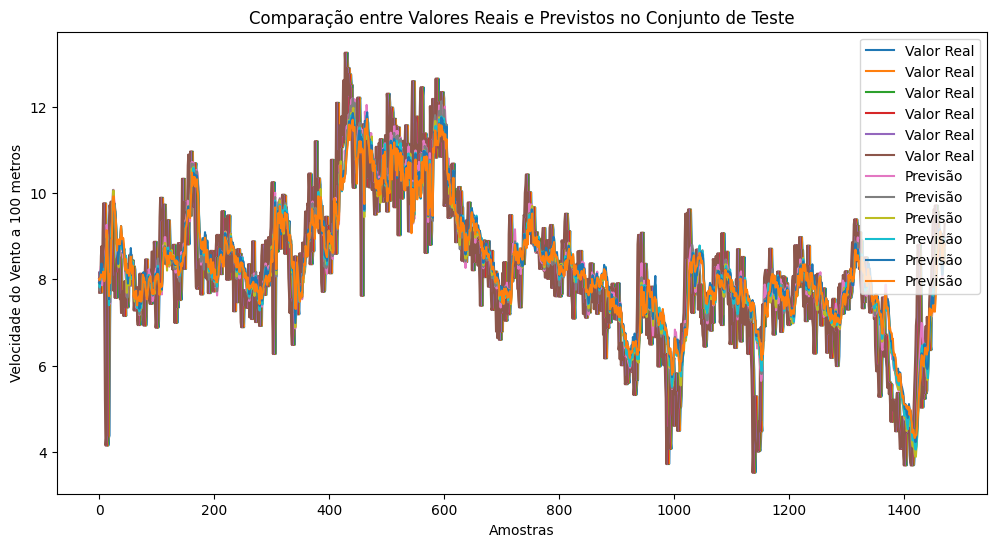

In [42]:
# Avaliação no conjunto de teste
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)

# Previsão no conjunto de teste
# Avaliação no conjunto de teste focando no sexto passo
y_pred = model.predict(X_test)
y_pred_inv = y_pred * std_ws100 + mean_ws100
y_test_inv = y_test * std_ws100 + mean_ws100

# Métricas de desempenho
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE no teste: {mae:.2f}")
print(f"RMSE no teste: {rmse:.2f}")
print(f"MAPE no teste: {mape:.2f}%")

# Sexto passo
y_pred_sixth = y_pred_inv[:, 5]
y_test_sixth = y_test_inv[:, 5]

# Métricas
mae = mean_absolute_error(y_test_sixth, y_pred_sixth)
rmse = np.sqrt(mean_squared_error(y_test_sixth, y_pred_sixth))
mape = np.mean(np.abs((y_test_sixth - y_pred_sixth) / y_test_sixth)) * 100

print(f"MAE no sexto passo: {mae:.2f}")
print(f"RMSE no sexto passo: {rmse:.2f}")
print(f"MAPE no sexto passo: {mape:.2f}%")

# Plotagem das previsões
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valor Real')
plt.plot(y_pred_inv, label='Previsão')
plt.legend()
plt.title('Comparação entre Valores Reais e Previstos no Conjunto de Teste')
plt.xlabel('Amostras')
plt.ylabel('Velocidade do Vento a 100 metros')
plt.show()
